# Project -- Analysing IRA tweets --

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import glob
from translate import Translator
import spacy
import findspark
import nltk
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names
from urllib.parse import urlparse
import requests
from unshortenit import UnshortenIt
 
findspark.init()

import networkx as nx

from pyspark import SparkContext

from pyspark.sql import *
from pyspark.sql.functions import to_timestamp, isnan
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import explode
from pyspark.sql.functions import col, when, length

import warnings # comment if you want to get the warnings from Searborn... ;) 
warnings.filterwarnings("ignore")
%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [2]:
# set up data directory
DATA_DIR = 'data/'

There are two main parts in this current *Jupyter Notebook* :

* 1) **GETTING TO KNOW OUR MAIN DATASETS**. We intend to understand what contain our datasets (features and their dtypes) and to clean them in order to be ready for interpretation. We also may want to split or create new sub-datasets if there are interesting opportunities to do so.


* 2) **DESCRIPTIVE STATISTICS AND PROJECT FEASABILITY**. In this part of the notebook we want to give summary statistics about the datasets we will need the most for our project. Furthermore we will try to figure out whether or not our objectives of Milestone 1 are still feasible after the reading of our datasets. 

## 1. GETTING TO KNOW OUR MAIN DATASETS

### loading the data

In [3]:
# taking IRAN tweets into account or not 
include_iran = False

In [4]:
# load datasets thanks to Spark CSV reader 

if include_iran:
    
    # combine both RUS and IRAN datasets
    include_description = 'RUS & IRAN'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_user.csv')

else:
    
    # take only RUS datasets
    include_description = 'RUS'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_user.csv')

In [5]:
# look at the raw global datasets' sizes 

# n : number of observations
n_text = tweets_text_df.count()
n_stats = tweets_stats_df.count()
n_metadata = tweets_meta_df.count()
n_users = tweets_user_df.count()

# d : dimensionality of the data 
d_text = len(tweets_text_df.columns)
d_stats = len(tweets_stats_df.columns)
d_metadata = len(tweets_meta_df.columns)
d_users =  len(tweets_user_df.columns)

# print the results 
print(' Sizes of the datasets : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of troll_tweet_text : '+str((n_text,d_text)))
print('size of troll_tweet_stats : '+str((n_stats,d_stats)))
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))
print('size of troll_user : '+str((n_users,d_users)))

 Sizes of the datasets : (RUS)
 --------------------------------------------------------
size of troll_tweet_text : (9041308, 3)
size of troll_tweet_stats : (9041308, 17)
size of troll_tweet_metadata : (9041308, 6)
size of troll_user : (3667, 11)


Roughly more than 9M tweets are available from RUS datasets (10M when combining both RUS AND IRAN). If after the cleaning there remains such a large number of data points, it's most likely that our statistical tests will present some significance if there are really underlying correlations, differences ... etc. 

We can assume, since the number of records for each dataframe is the same and because of the '*a priori*' description of the data, that the rows are ordered in such a way that every tuple of index $i$ in '*troll_tweet_text*' corresponds to the observations at index $i$ for '*troll_tweet_stats*' and '*troll_tweet_metadata*'. 

### tweets_text

In [6]:
# what does tweets_text look like ? size, dtypes
print((n_text,d_text))
tweets_text_df.dtypes

(9041308, 3)


[('tweetid', 'string'), ('tweet_language', 'string'), ('tweet_text', 'string')]

In [7]:
# a quick view
tweets_text_df.show(10)

+------------------+--------------+--------------------+
|           tweetid|tweet_language|          tweet_text|
+------------------+--------------+--------------------+
|877919995476496385|            ru|"RT @ruopentwit: ...|
|492388766930444288|            ru|Серебром отколоко...|
|719455077589721089|            bg|@kpru С-300 в Ира...|
|536179342423105537|            ru|Предлагаю судить ...|
|841410788409630720|            bg|Предостережение а...|
|834365760776630272|            ru|Двойная утопия, и...|
|577490527299457024|            ru|RT @harkovnews: Н...|
|596522755379560448|            ru|RT @NovostiNsk: «...|
|567357519547207680|            en|As sun and cloud ...|
|665533117369876480|            ru|RT @vesti_news: Ш...|
+------------------+--------------+--------------------+
only showing top 10 rows



***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Unknown *tweet_language* can take both the value 'und', or null. We harmonize this column by setting all NaN to 'und'.

In [8]:
tweets_text_df = tweets_text_df.fillna('und',['tweet_language'])

### tweets_stats

In [9]:
# what does tweets_stats look like ? size, dtypes
print((n_stats,d_stats))
tweets_stats_df.dtypes

(9041308, 17)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'string'),
 ('in_reply_to_tweetid', 'string'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('is_retweet', 'string'),
 ('retweet_userid', 'string'),
 ('retweet_tweetid', 'string'),
 ('quote_count', 'string'),
 ('reply_count', 'string'),
 ('like_count', 'string'),
 ('retweet_count', 'string'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

In [10]:
# (a view is not adapted in the current context)
# tweets_stats_df.show(10)

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the *tweet_time* into Datetime for ease of use, and we cast some columns into integers. We also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [11]:
# dtypes transformations : 
tweets_stats_df = tweets_stats_df.withColumn('tweet_time', to_timestamp(tweets_stats_df.tweet_time))
tweets_stats_df = tweets_stats_df.withColumn('quote_count', tweets_stats_df.quote_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('reply_count', tweets_stats_df.reply_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('like_count', tweets_stats_df.like_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('retweet_count', tweets_stats_df.retweet_count.cast('int'))

# create a temporary Spark SQL view
tweets_stats_df.createOrReplaceTempView("tweets_stats_sql")

Now we can start splitting the data into smaller dataframes and remove the useless columns for each of those:
* **retweets_df** contains all the posts that are retweets.
* **replies_df** contains all the posts that are replies to other tweets.
* **normal_tweets_df** contains all the other ('normal') posts.

**NB:** some tweets have a value for *in_reply_to_userid* while their *in_reply_to_tweetid* is null (however the inverse never happens). Those are either replies to deleted tweets, or mentions of other users that were treated as replies. We decided to consider them as normal tweets.

In [12]:
# RETWEETS
retweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=True")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in retweets_df:
    #retweets_df.select(col).distinct().show(10)

# drop certain features
retweets_df = retweets_df.drop('in_reply_to_tweetid', 'in_reply_to_userid', 'is_retweet',\
                               'quote_count', 'reply_count', 'like_count', 'retweet_count',\
                               'poll_choices')

# record the size of the created sub-dataset
n_retweets = retweets_df.count()
d_retweets = len(retweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of retweets : '+str((n_retweets,d_retweets)))


 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of retweets : (3333184, 9)


In [13]:
# REPLIES
replies_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NOT NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in replies_df:
    #replies_df.select(col).distinct().show(10)

# record the size of the created sub-dataset
replies_df = replies_df.drop('retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_replies = replies_df.count()
d_replies = len(replies_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of replies : '+str((n_replies,d_replies)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of replies : (266208, 14)


In [14]:
# NORMAL
normal_tweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in normal_tweets_df:
    #normal_tweets_df.select(col).distinct().show(10)
    
# record the size of the created sub-dataset
normal_tweets_df = normal_tweets_df.drop('in_reply_to_tweetid', 'retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_normal = normal_tweets_df.count()
d_normal = len(normal_tweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of normal tweets : '+str((n_normal,d_normal)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of normal tweets : (5441916, 13)


We verify that the number of rows correspond and that we did not duplicate or remove any by accident.

In [15]:
print(str(n_stats)+' vs. '+str(n_retweets+n_normal+n_replies))

9041308 vs. 9041308


### tweets_meta

In [16]:
# what does tweets_stats look like ? size, dtypes
print((n_metadata,d_metadata))
tweets_meta_df.dtypes

(9041308, 6)


[('tweetid', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('tweet_client_name', 'string')]

In [17]:
# a quick view
tweets_meta_df.show(10)

+------------------+--------------+---------------+--------+---------+------------------+
|           tweetid|follower_count|following_count|latitude|longitude| tweet_client_name|
+------------------+--------------+---------------+--------+---------+------------------+
|849295393867399169|          4042|           1470|    null|     null|Twitter Web Client|
|567280957913587713|           272|            390|    null|     null|          iziaslav|
|493095247690612736|            89|            223|    null|     null|          vavilonX|
|493892174069903360|            89|            223|    null|     null|          vavilonX|
|512503798506721280|            89|            223|    null|     null|          vavilonX|
|499624206246871041|            89|            223|    null|     null|          vavilonX|
|491828568251707392|            89|            223|    null|     null|          vavilonX|
|493768356810731520|            89|            223|    null|     null|          vavilonX|
|502221368

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Just as with the previous dataset, we cast some columns into integers and we also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [18]:
# dtypes transformations : 
tweets_meta_df = tweets_meta_df.withColumn('follower_count', tweets_meta_df.follower_count.cast('int'))
tweets_meta_df = tweets_meta_df.withColumn('following_count', tweets_meta_df.following_count.cast('int'))

# NOTE : we do not cast lattitude/longitude columns into integers since we intend to drop both 
# columns (see below why).

# create a temporary Spark SQL view
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

It appears that the number of rows with a non-null *latitude*/*longitude* combination is very small compared to the size of dataset (less than 0.05%). Furthermore, several of them are repeated. We thus consider it rather useless and prefer dropping it.

@answer : **REPEATED, is it really BAD ?** 

In [19]:
temp = spark.sql("SELECT * FROM tweets_meta_sql WHERE latitude IS NOT NULL")
print('total number of observations for this data set '+str(n_metadata))
print('number of non NULL lattitude records : '+str(temp.count())+ ' and among them '+str(temp.select('latitude', 'longitude').distinct().count())+' unique coordinates pairs')

# drop lattitude and longitude 
tweets_meta_df = tweets_meta_df.drop('latitude', 'longitude')
      
# override previous TempView
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

total number of observations for this data set 9041308
number of non NULL lattitude records : 4779 and among them 2938 unique coordinates pairs


The main feature that we can use to split the data here is *tweet_client_name*. When we take a closer look to this column, we discover that there are more than 400 values registered. Many of them seem unidentifiable.

However, we can see that a good amount of tweets are sent through official Twitter applications:
* **Twitter Web Client** accounts for around one third of the tweets in the dataset.
* **TweetDeck**, which allows to manage multiple accounts simultaneously, handles around 7% of the tweets.
* **Twitter For Android** is also in the top 15 applications used for those tweets.

Most of the other tweets are generated through automated social media managers, such as **twitterfeed** (which had been shut down in 2016), **dlvr.it**, or even **IFTTT**.

In [20]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql GROUP BY tweet_client_name ORDER BY count DESC")
print('number of twitter clients : '+str(temp.count()))
temp.show(15)

number of twitter clients : 334
+-------------------+-------+
|  tweet_client_name|  count|
+-------------------+-------+
| Twitter Web Client|2576596|
|        twitterfeed|1472547|
|          TweetDeck| 612024|
|      newtwittersky| 393074|
|          bronislav| 308516|
|           iziaslav| 299963|
|              IFTTT| 291269|
|          rostislav| 289475|
|        generationπ| 285503|
|         Twibble.io| 268402|
|    Ohwee Messanger| 240051|
|NovaPress Publisher| 204583|
|Twitter for Android| 163227|
|Приложение для тебя| 159588|
|           vavilonX| 148744|
+-------------------+-------+
only showing top 15 rows



Let's have a look on Twitter clients of the kind : *Twitter ... for ....*.

In [21]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql WHERE tweet_client_name LIKE '%Twitter%' GROUP BY tweet_client_name ORDER BY count DESC")
print('number of such typical twitter clients : '+str(temp.count()))
temp.show()

number of such typical twitter clients : 18
+--------------------+-------+
|   tweet_client_name|  count|
+--------------------+-------+
|  Twitter Web Client|2576596|
| Twitter for Android| 163227|
|  Twitter for iPhone|  56168|
|Twitter for Andro...|  22126|
|    Twitter for iPad|   4432|
|Twitter for  Android|   3642|
|        Twitter Lite|   2891|
|      Twitter Nation|    813|
|Twitter for Websites|    762|
|Twitter for Nokia...|    442|
|Twitter for Black...|     92|
| Twitter for Windows|     92|
|Twitter for Black...|     71|
|Twitterrific for iOS|     21|
|Twitter for Windo...|      9|
|         Twitter Ads|      6|
|Twitter Business ...|      2|
|Unfollow Tools fo...|      1|
+--------------------+-------+



In the end, seeing how messy this dataset is, and how few columns it has, we decided to not split it.

In [22]:
# update the dimensionality of this dataset after the drop of columns
d_metadata=  len(tweets_meta_df.columns)
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))

size of troll_tweet_metadata : (9041308, 4)


### tweets_user

In [23]:
# what does tweets_stats look like ? size, dtypes
print((n_users,d_users))
tweets_user_df.dtypes

(3667, 11)


[('userid', 'string'),
 ('user_display_name', 'string'),
 ('user_screen_name', 'string'),
 ('user_reported_location', 'string'),
 ('user_profile_description', 'string'),
 ('user_profile_url', 'string'),
 ('account_creation_date', 'string'),
 ('account_language', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('last_tweet_at', 'string')]

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the dates and integers present in the dataframe. This also treats the wrong encodings in those columns (such as a language ('en') present in *last_tweet_at*.

In [24]:
# dtypes transformations : 
tweets_user_df = tweets_user_df.withColumn('account_creation_date', to_timestamp(tweets_user_df.account_creation_date))
tweets_user_df = tweets_user_df.withColumn('last_tweet_at', to_timestamp(tweets_user_df.last_tweet_at))
tweets_user_df = tweets_user_df.withColumn('follower_count', tweets_user_df.follower_count.cast('int'))
tweets_user_df = tweets_user_df.withColumn('following_count', tweets_user_df.following_count.cast('int'))

# create a temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

There also appear to be some wrong encodings in *account_language*. All languages are represented by a two letters code (except for *en-gb* and *zh-cn*, which correspond respectively to British English and Mainland Chinese). But a very small number of rows contain a date or a text as language.

After looking further into that, we discovered that those accounts wrote tweets in many different languages. As it is impossible for us to determine which one is their preferred language, we decided to set those inconsistent values to *'und'*.

In [25]:
temp = spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5")
print("number of rows with inconsistent account_language: " + str(temp.count()))
temp.show()

number of rows with inconsistent account_language: 3
+--------------------+----------------+
|              userid|account_language|
+--------------------+----------------+
|02b81295dbf8951d1...|      2016-01-13|
|          1240007161|      2013-03-03|
|8e77873eecf19db8d...|      2017-03-21|
+--------------------+----------------+



Let's apply the transformations required by the last comments. 

In [26]:
# filter on the account_language feature
tweets_user_df = tweets_user_df.withColumn('account_language', when(length(col('account_language'))>5, 'und').otherwise(col('account_language')))

In [27]:
# create temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

Let's check that there are no more 'inconsistent' rows w.r.t our standards.

In [28]:
print("number of rows with inconsistent account_language: " + str(spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5").count()))

number of rows with inconsistent account_language: 0


We then split this dataframe into two:
* **anonymized_user_df** contains all the users that are anonymized.
* **exposed_user_df** contains all the other users.

This allows us to drop two columns for the anonymized users (users that have a *userid* that's the same as their *user_display_name* and *user_screen_name* : [Google APIs : twitter election integrity](https://storage.googleapis.com/twitter-election-integrity/hashed/Twitter_Elections_Integrity_Datasets_hashed_README.txt)) , which are a majority.

In [29]:
anonymized_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE userid=user_display_name")
exposed_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE NOT userid=user_display_name")

# drop useless columns 
anonymized_user_df = anonymized_user_df.drop('user_display_name', 'user_screen_name')

# print results + check that there are only two outcomes possible for userid = user_display_name
print('number of records from dataset user : '+str(n_users))
print('wherein there are '+str(anonymized_user_df.count())+' anonymized accounts and '+\
      str(exposed_user_df.count())+' exposed accounts')

number of records from dataset user : 3667
wherein there are 3500 anonymized accounts and 167 exposed accounts


### Summary

We have generated 4 main dataframes from the data files: *tweets_text_df*, *tweets_stats_df*, *tweets_meta_df*, and *tweets_user_df*. We then cleaned the inconsistent values and split those dataframes into smaller ones when possible and useful. Our data is now organised as follows:

* **tweets_text_df**: all the contents from the tweets, with an indication of their language.
* **tweets_stats_df**: 
    * **retweets_df**: all the information about retweets.
    * **replies_df**: all the information about replies.
    * **normal_tweets_df**: all the information about the other tweets.
* **tweets_meta_df**: all the meta information corresponding to each tweets (minus the latitude/longitude).
* **tweets_user_df**:
    * **anonymized_user_df**: all the information about anonymized users.
    * **exposed_user_df**: all the information about users who are not anonymized.
    

Before digging into some statistics we would like to underline the fact we can handle the data in its current size with the use of Spark. Previous requests did not take that much time with Spark SQL and the fact that our dataset is well partionned among several sub-datasets (data chunks) of interest will prevent us to query on too large files ! If we request very intensive computations on the data that embed many and many accesses to these chunks we will either make use of *Parquet* files or we will ***persist()*** Spark dataframes to keep them on top of the memory.
We can tell we won't need to use ADA's cluster.

## 2.  DESCRIPTIVE STATISTICS OF OUR DATASETS AND PROJECT FEASABILITY

As a short reminder, the questions we would like to address with respect to the milestone 1 were  : 
* 1) Is there a relation between the candidates popularities and the activities of the trolls?
* 2) Did the trolls influence the major events of the campaign? Is it the other way around? 
* 3) Which subjects are discussed by the trolls, and which semantics do they use?
* 4) Which media do they tend to talk about and link in their posts?
* 5) Do they tend to show direct support or hatred for specific people?
* 6) Did the strategy of the trolls change over time?
    
-------------------------------------------------------------------------------------------------

In [30]:
# create temporary Spark SQL views of our data chunks :

# normal_tweets_df
normal_tweets_df.createOrReplaceTempView("normal_tweets_sql")

# tweets_text_df
tweets_text_df.createOrReplaceTempView("tweets_text_sql")

# tweets_meta_df
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

# tweets_user_df
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

# NEW STUFF

## RETWEETS

Let us take a look at the retweets: what was retweeted by and from the trolls, and by who. We are going to take a look at the numbers, and to build a graph with the interesting relationships.

### Build dataframes

In [31]:
retweets_df.createOrReplaceTempView("retweets_sql")

#### Retweets and count

We first count the number of posts that *userid* retweeted from *retweet_userid*.

In [32]:
retweets_edges_df = spark.sql("SELECT userid, retweet_userid, COUNT(*) AS count FROM retweets_sql GROUP BY userid, retweet_userid ORDER BY count DESC")
retweets_edges_df.createOrReplaceTempView("retweets_edges_sql")
print(retweets_edges_df.count(), len(retweets_edges_df.columns))
retweets_edges_df.show(5)

844950 3
+--------------------+--------------+-----+
|              userid|retweet_userid|count|
+--------------------+--------------+-----+
|a95a911dd6ae864c4...|    2746979823| 9875|
|a95a911dd6ae864c4...|       1367531| 2840|
|a95a911dd6ae864c4...|      25073877| 2498|
|74ceb7c6a46a5beb0...|    2577412818| 1743|
|          4859142199|    3312143142| 1624|
+--------------------+--------------+-----+
only showing top 5 rows



#### Outdegree

We are now interested in knowing how many retweets each troll performed (outdegree of the retweets graph).

In [33]:
retweets_outdegree_df = spark.sql("SELECT userid, SUM(count) AS outdegree FROM retweets_edges_sql GROUP BY userid ORDER BY outdegree DESC")
retweets_outdegree_df.createOrReplaceTempView("retweets_outdegree_sql")
print(retweets_outdegree_df.count(), len(retweets_outdegree_df.columns))
retweets_outdegree_df.show(5)

2975 2
+--------------------+---------+
|              userid|outdegree|
+--------------------+---------+
|a95a911dd6ae864c4...|   128897|
|cfb0d237487ebe352...|    36894|
|          3438999494|    26973|
|396b0b6914e425ca5...|    17980|
|0994abf9fb8fe1bf6...|    16960|
+--------------------+---------+
only showing top 5 rows



In [34]:
retweets_outdegree_df.describe().show()

+-------+--------------------+------------------+
|summary|              userid|         outdegree|
+-------+--------------------+------------------+
|  count|                2975|              2975|
|   mean|1.119043723887934...|1120.3979831932772|
| stddev|2.821889341538021...| 3093.046668622982|
|    min|004c1875a5f3a8ddf...|                 1|
|    max|ffe3cd0f54e1859e0...|            128897|
+-------+--------------------+------------------+



#### Indegree

We do the same for the indegree of the retweets graph.

In [35]:
retweets_indegree_df = spark.sql("SELECT retweet_userid, SUM(count) AS indegree FROM retweets_edges_sql GROUP BY retweet_userid ORDER BY indegree DESC")
retweets_indegree_df.createOrReplaceTempView("retweets_indegree_sql")
print(retweets_indegree_df.count(), len(retweets_indegree_df.columns))
retweets_indegree_df.show(5)

204289 2
+--------------+--------+
|retweet_userid|indegree|
+--------------+--------+
|      34200559|  123830|
|      32421706|   79030|
|    2570574680|   70395|
|     338960856|   67521|
|      72525490|   50560|
+--------------+--------+
only showing top 5 rows



#### Reduction

The graph is way too big to be manipulated. We reduce it to keep only the nodes that have either retweeted at least once or been retweeted more than 10 times.

In [36]:
retweets_indegree_small_df = spark.sql("SELECT * FROM retweets_indegree_sql WHERE indegree>10")
print(retweets_indegree_small_df.count())

16108


In [37]:
retweets_edges_small_df = retweets_edges_df.join(retweets_indegree_small_df, ['retweet_userid'])
retweets_edges_small_df = retweets_edges_small_df.join(retweets_outdegree_df, ['userid'])
print(retweets_edges_small_df.count())

533060


In [38]:
retweets_edges_small_df.describe().show()

+-------+--------------------+--------------------+------------------+------------------+------------------+
|summary|              userid|      retweet_userid|             count|          indegree|         outdegree|
+-------+--------------------+--------------------+------------------+------------------+------------------+
|  count|              533060|              533060|            533060|            533060|            533060|
|   mean|2.092886738435057...|3.062322930562337...|  5.58824334971673|2023.8185288710465| 4593.699915581736|
| stddev|1.318995774897990...|1.493328410978443...|25.572339631075646| 7701.910473550255|10463.071323139386|
|    min|004c1875a5f3a8ddf...|004c1875a5f3a8ddf...|                 1|                11|                 1|
|    max|ffe3cd0f54e1859e0...|ffe3cd0f54e1859e0...|              9875|            123830|            128897|
+-------+--------------------+--------------------+------------------+------------------+------------------+



In [39]:
retweets_edges_small_pd = retweets_edges_small_df.toPandas()

### Exposed users

To furthermore reduce our graph, we will now focus on users that are not anonymized. We consider them more interesting because we can obtain more information about them and because they were by definition more popular than anonymized accounts.

#### Exposed source

In [40]:
retweets_edges_small_df.createOrReplaceTempView("retweets_edges_small_sql")
exposed_user_df.createOrReplaceTempView("exposed_user_sql")
retweets_exposed_out = retweets_edges_small_df.join(exposed_user_df, ['userid'])
retweets_exposed_out.createOrReplaceTempView("retweets_exposed_out_sql")
retweets_exposed_out_df = spark.sql("SELECT userid, user_display_name, user_screen_name, retweet_userid, account_language, count, indegree, outdegree FROM retweets_exposed_out_sql")
retweets_exposed_out_pd = retweets_exposed_out_df.toPandas()

In [41]:
print(retweets_exposed_out_pd.shape)
retweets_exposed_out_pd.head()

(32804, 8)


,userid,user_display_name,user_screen_name,retweet_userid,account_language,count,indegree,outdegree
0,1240007161,Замполит,ComradZampolit,143469704,und,3,25,6323
1,1240007161,Замполит,ComradZampolit,1715286739,und,2,243,6323
2,1240007161,Замполит,ComradZampolit,219653959,und,3,65,6323
3,1240007161,Замполит,ComradZampolit,2302557678,und,2,31,6323
4,1240007161,Замполит,ComradZampolit,3039501256,und,1,20,6323


#### Exposed destination

In [42]:
retweets_exposed_in = retweets_edges_small_df.join(exposed_user_df.withColumnRenamed('userid', 'retweet_userid'), ['retweet_userid'])
retweets_exposed_in.createOrReplaceTempView("retweets_exposed_in_sql")
retweets_exposed_in_df = spark.sql("SELECT userid, user_display_name AS retweet_user_display_name, user_screen_name AS retweet_user_screen_name, retweet_userid, account_language AS rt_account_language, count AS rt_count, indegree AS rt_indegree, outdegree AS rt_outdegree FROM retweets_exposed_in_sql")
retweets_exposed_in_pd = retweets_exposed_in_df.toPandas()

In [43]:
print(retweets_exposed_in_pd.shape)
retweets_exposed_in_pd.head()

(32605, 8)


,userid,retweet_user_display_name,retweet_user_screen_name,retweet_userid,rt_account_language,rt_count,rt_indegree,rt_outdegree
0,202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc46...,Замполит,ComradZampolit,1240007161,und,19,14831,6111
1,202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc46...,Вестник России,vestnikrus,2481527106,ru,29,15544,6111
2,202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc46...,Открытая Россия,ruopentwit,2572896396,ru,25,17841,6111
3,202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc46...,Викулова Татьяна,sinigopajuby,2256210373,en,3,672,6111
4,202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc46...,Вестник Петербурга,NovostiSPb,508761973,en,35,22366,6111


#### Join both

In [44]:
retweets_exposed_df = retweets_exposed_out_df.join(retweets_exposed_in_df, ['userid', 'retweet_userid'])
retweets_exposed_pd = retweets_exposed_df.toPandas()
print(retweets_exposed_pd.shape)
retweets_exposed_pd.head()

(1145, 14)


,userid,retweet_userid,user_display_name,user_screen_name,account_language,count,indegree,outdegree,retweet_user_display_name,retweet_user_screen_name,rt_account_language,rt_count,rt_indegree,rt_outdegree
0,1240007161,2526297190,Замполит,ComradZampolit,und,9,14,6323,АгитПолк,AgitPolk,ru,9,14,6323
1,2532611755,2882013788,Kathie,KathieMrr,en,105,6082,3433,Giselle Evans,GiselleEvns,en,105,6082,3433
2,2721995401,2808833544,Мария Можайская,MaryMozhaiskaya,en,9,19753,296,Максим Дементьев,MaxDementiev,ru,9,19753,296
3,3049228218,3806028575,Вестник Луганска,LuganskNovosti,ru,1,214,213,Вестник Тулы,VestnikTula,ru,1,214,213
4,508761973,2808833544,Вестник Петербурга,NovostiSPb,en,11,19753,1930,Максим Дементьев,MaxDementiev,ru,11,19753,1930


#### Initialize graph

In [45]:
retweet_exposed_graph = nx.from_pandas_edgelist(retweets_exposed_pd, 'userid', 'retweet_userid', edge_attr='count', create_using= nx.DiGraph())

#### Node attributes
We define several node attributes that can be useful for later visualisation: indegree, outdegree and degree (sum of in and out) ; display and screen name ; account language.

In [46]:
dict_indeg = dict(zip(retweets_exposed_pd.retweet_userid, retweets_exposed_pd.indegree))
dict_outdeg = dict(zip(retweets_exposed_pd.userid, retweets_exposed_pd.outdegree))
dict_display = dict(zip(retweets_exposed_pd.retweet_userid, retweets_exposed_pd.retweet_user_display_name))
dict_display.update(dict(zip(retweets_exposed_pd.userid, retweets_exposed_pd.user_display_name)))
dict_screen = dict(zip(retweets_exposed_pd.retweet_userid, retweets_exposed_pd.retweet_user_screen_name))
dict_screen.update(dict(zip(retweets_exposed_pd.userid, retweets_exposed_pd.user_screen_name)))
dict_lang = dict(zip(retweets_exposed_pd.retweet_userid, retweets_exposed_pd.rt_account_language))
dict_lang.update(dict(zip(retweets_exposed_pd.userid, retweets_exposed_pd.account_language)))

nx.set_node_attributes(retweet_exposed_graph, dict_indeg, name="indegree")
nx.set_node_attributes(retweet_exposed_graph, dict_outdeg, name="outdegree")
nx.set_node_attributes(retweet_exposed_graph, dict_display, name="display")
nx.set_node_attributes(retweet_exposed_graph, dict_screen, name="screen")
nx.set_node_attributes(retweet_exposed_graph, dict_lang, name="lang")

In [47]:
print(len(dict_indeg))
print(len(dict_outdeg))
print(len(dict_display))
print(len(dict_screen))
print(len(dict_lang))
print(nx.info(retweet_exposed_graph))

122
108
137
137
137
Name: 
Type: DiGraph
Number of nodes: 137
Number of edges: 1145
Average in degree:   8.3577
Average out degree:   8.3577


#### Write graph
We finally save the graph as a *gexf* file that can be used with *Gephi*.g

In [48]:
nx.write_gexf(retweet_exposed_graph, "retweet_exposed_graph.gexf")

### Observations

Let us now dig deeper and look more precisely into the details of our data.

#### Main retweeters
We first observe the exposed trolls that performed the most retweets.

In [49]:
most_rt_out = retweets_outdegree_df.join(exposed_user_df.select('userid', 'user_screen_name', 'user_display_name', 'account_language'), ['userid']).limit(20).toPandas()
colors = []
for l in most_rt_out['account_language']:
    if l=='en':
        colors.append('blue')
    else:
        colors.append('red')

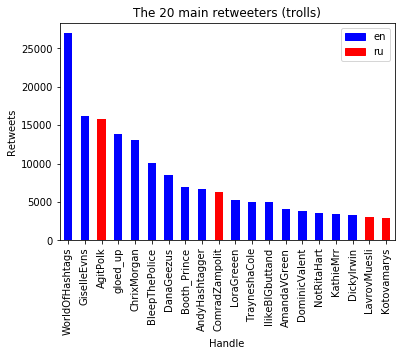

In [50]:
most_rt_out.head(20).plot.bar(x = "user_screen_name", y = "outdegree",legend=True, title="The 20 main retweeters (trolls)",grid=False, color = colors);
blue_patch = mpatches.Patch(color='blue', label='en')
red_patch = mpatches.Patch(color='red', label='ru')
plt.legend(handles=[blue_patch, red_patch])
plt.xlabel('Handle')
plt.ylabel('Retweets')
plt.savefig('retweeter_trolls.png', bbox_inches='tight', dpi=200, transparent=True)

#### Most retweeted
We look at the exposed accounts (non-trolls and trolls) that were the most retweeted by the trolls.

In [52]:
most_retweeted = retweets_indegree_df.limit(20).toPandas()

In [53]:
for index, row in most_retweeted.iterrows():
    if len(row['retweet_userid'])>10:
        most_retweeted.at[index, 'retweet_userid'] = (row['retweet_userid'])[:10]+"..."

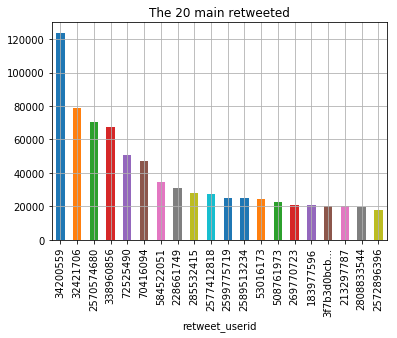

In [54]:
most_retweeted.plot.bar(x = "retweet_userid", y = "indegree",legend=False, title="The 20 main retweeted",grid=True);

Thanks to [tweeterid](https://tweeterid.com), we can easily identify the accounts that are not in our database. Note that some of them have been deleted.

In [55]:
userid_to_screen = ['rianru', 'GazetaRu', '', 'RT_russian', 'vesti_news', '', 'Pravdiva_pravda', 'lentaruofficial', 
                    'tass_agency', 'leprasorium', '', '', 'lifenews_ru', '', 'ru_rbc', 'champ_football', '[ANON]', 'izvestia_ru', '', '']

In [56]:
for i in range(0,len(userid_to_screen)):
    if userid_to_screen[i]=='':
        temp_req = spark.sql("SELECT user_screen_name FROM exposed_user_sql WHERE userid="+ most_retweeted.retweet_userid[i])
        if temp_req.count()>0:
            userid_to_screen[i] = temp_req.toPandas().user_screen_name[0]
        else:
            userid_to_screen[i] = '[DELETED]'

In [57]:
most_retweeted['user_screen_name'] = userid_to_screen

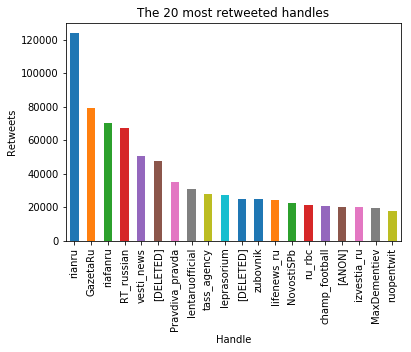

In [58]:
most_retweeted.plot.bar(x = "user_screen_name", y = "indegree",legend=False, title="The 20 most retweeted handles",grid=False)

plt.xlabel('Handle')
plt.ylabel('Retweets')
plt.savefig('retweeted_all.png', bbox_inches='tight', dpi=200, transparent=True)

We do the same but focused on the exposed trolls.

In [61]:
most_rt_in = retweets_indegree_df.withColumnRenamed('retweet_userid','userid').join(exposed_user_df.select('userid', 'user_screen_name', 'user_display_name', 'account_language'), ['userid']).toPandas()

In [62]:
colors = []
for l in most_rt_in['account_language'].head(20):
    if l=='en':
        colors.append('blue')
    else:
        colors.append('red')

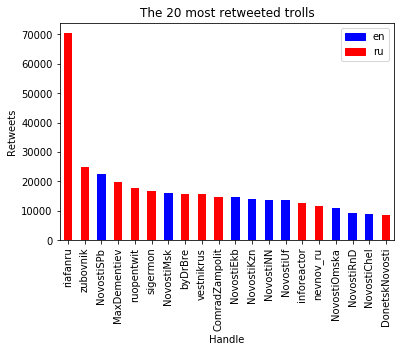

In [63]:
most_rt_in.head(20).plot.bar(x = "user_screen_name", y = "indegree",legend=False, title="The 20 most retweeted trolls",grid=False, color=colors);
blue_patch = mpatches.Patch(color='blue', label='en')
red_patch = mpatches.Patch(color='red', label='ru')
plt.legend(handles=[blue_patch, red_patch])
plt.xlabel('Handle')
plt.ylabel('Retweets')
plt.savefig('retweeted_trolls.png', bbox_inches='tight', dpi=200, transparent=True)

### Languages
Let us now see how Russian and English are distributed among the retweets.

In [65]:
retweets_lang_df = tweets_text_df['tweetid', 'tweet_language'].join(retweets_df.select(['tweetid']), ['tweetid'])
retweeted_lang_df = tweets_text_df['tweetid', 'tweet_language'].join((normal_tweets_df.select(['tweetid', 'retweet_count'])).union(replies_df.select(['tweetid', 'retweet_count'])), ['tweetid'])
retweets_lang_df.createOrReplaceTempView("retweets_lang_sql")
retweeted_lang_df.createOrReplaceTempView("retweeted_lang_sql")

In [66]:
retweets_lang_count = spark.sql("SELECT tweet_language, COUNT(*) AS count FROM retweets_lang_sql GROUP BY tweet_language ORDER BY count DESC")
retweeted_lang_count = spark.sql("SELECT tweet_language, SUM(retweet_count) AS count FROM retweeted_lang_sql GROUP BY tweet_language ORDER BY count DESC")

In [67]:
retweets_lang_count_pd = retweets_lang_count.toPandas()
retweeted_lang_count_pd = retweeted_lang_count.toPandas()

In [68]:
print(retweets_lang_count_pd.shape)
print(retweeted_lang_count_pd.shape)

(52, 2)
(56, 2)


#### Languages retweeted by the trolls

In [69]:
retweets_lang_count_pd.head(10)

,tweet_language,count
0,ru,2013563
1,en,1083622
2,und,122182
3,uk,32348
4,bg,18114
5,it,17883
6,de,13073
7,fr,5135
8,es,4400
9,in,2782


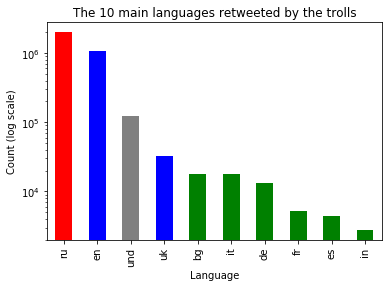

In [70]:
colors = ['red', 'blue', 'grey', 'blue']
colors.extend(['green']*(10-len(colors)))
retweets_lang_count_pd.head(10).plot.bar(x = "tweet_language", y = "count",legend=False, title="The 10 main languages retweeted by the trolls",grid=False, color=colors)
plt.yscale('log')
plt.xlabel('Language')
plt.ylabel('Count (log scale)')
plt.savefig('retweets_lang.png', bbox_inches='tight', dpi=200, transparent=True)

#### Languages in posts from the trolls that were retweeted

In [71]:
retweeted_lang_count_pd.head(10)

,tweet_language,count
0,en,21913266
1,ru,8530216
2,und,537911
3,uk,86902
4,de,74693
5,bg,48344
6,fr,7201
7,sr,6984
8,in,6590
9,ar,6579


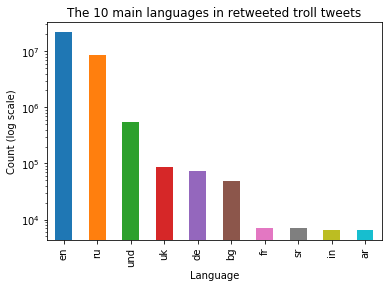

In [72]:
retweeted_lang_count_pd.head(10).plot.bar(x = "tweet_language", y = "count",legend=False, title="The 10 main languages in retweeted troll tweets",grid=False)
plt.yscale('log')
plt.xlabel('Language')
plt.ylabel('Count (log scale)')
plt.savefig('retweets_lang.png', bbox_inches='tight', dpi=200, transparent=True)

## URLs in Tweets

We now take a closer look at the urls that can be found in the troll tweets.
We first need to gather all those urls, and sort them by language.

In [31]:
tweets_stats_df['tweetid','urls'].createOrReplaceTempView("urls_sql")
urls_df = spark.sql("SELECT tweetid, urls FROM urls_sql WHERE urls IS NOT NULL AND NOT urls='[]'")

In [32]:
tweets_url_lang_df = urls_df.join(tweets_text_df.select('tweetid', 'tweet_language'), ['tweetid'])
tweets_url_lang_df.createOrReplaceTempView("tweets_url_lang_sql")
tweets_url_en_df = spark.sql("SELECT urls FROM tweets_url_lang_sql WHERE tweet_language='en'")
tweets_url_ru_df = spark.sql("SELECT urls FROM tweets_url_lang_sql WHERE tweet_language='ru'")
tweets_url_other_df = spark.sql("SELECT urls FROM tweets_url_lang_sql WHERE NOT (tweet_language='en' OR tweet_language='ru')")

In [33]:
print(tweets_url_lang_df.count())
print(tweets_url_en_df.count())
print(tweets_url_ru_df.count())
print(tweets_url_other_df.count())

4590337
1142115
3032919
415303


In [36]:
def parse_url(url_df):
    urls_array_list = []
    for r in url_df.select('urls').collect():
            urls_array_list.append((r['urls'])[1:-1].split(", "))
    urls_list = [item for sublist in urls_array_list for item in sublist]
    return urls_list

In [37]:
en_urls_list = parse_url(tweets_url_en_df)
ru_urls_list = parse_url(tweets_url_ru_df)
other_urls_list = parse_url(tweets_url_other_df)
print(len(en_urls_list), len(ru_urls_list), len(other_urls_list))

1169882 3039821 425974


In [38]:
def build_url_df(urls_list):
    all_urls = {}
    for u in urls_list:
        if u in all_urls:
            all_urls[u] += 1
        else:
            all_urls[u] = 1
    sorted_urls = sorted(all_urls, key=all_urls.get, reverse=True)
    urls_df = pd.DataFrame()
    urls_df['url'] = sorted_urls
    urls_df['count'] = urls_df['url'].map(lambda x: all_urls[x])
    return urls_df

In [42]:
en_urls_pd = build_url_df(en_urls_list)
ru_urls_pd = build_url_df(ru_urls_list)
other_urls_pd = build_url_df(other_urls_list)

In [84]:
all_urls_pd = en_urls_pd.set_index('url').join(ru_urls_pd.set_index('url'), how="outer", lsuffix='_en', rsuffix='_ru')
all_urls_pd = all_urls_pd.join((other_urls_pd.set_index('url')).rename({'count':'count_other'}, axis='columns'), how="outer")
all_urls_pd.fillna(0, inplace=True)
all_urls_pd['count'] = (all_urls_pd['count_other']+all_urls_pd['count_en']+all_urls_pd['count_ru']).astype(int)

In [89]:
all_urls_pd.sort_values('count', inplace=True, ascending=False)
all_urls_pd.head(10)

,count_en,count_ru,count_other,count
url,,,,
http://1063.mobi,4357.0,0.0,71.0,4428
http://USFREEDOMARMY.COM,3662.0,0.0,0.0,3662
http://kiev-news.com/13876-detskaya-bolnica-v-donecke-popala-pod-obstrel.html,0.0,2867.0,0.0,2867
http://kievsmi.net/novosti/politics/47097-klimkin-peregovory-ukrainy-i-rossii-idut-neprosto.html,0.0,2800.0,1.0,2801
http://bit.ly/1D3LvAc,2369.0,0.0,0.0,2369
http://kiev-news.com/13872-v-kieve-shkolnikov-uchat-kak-vesti-sebya-pri-zaminirovanii.html,0.0,2178.0,0.0,2178
http://Covfefe.bz,2035.0,0.0,19.0,2054
https://twibble.io,1719.0,136.0,34.0,1889
http://www.theunder.us,1255.0,0.0,62.0,1317


In [88]:
all_urls_pd.describe()

,count_en,count_ru,count_other,count
count,2.776243e+06,2.776243e+06,2.776243e+06,2.776243e+06
mean,4.213903e-01,1.094941e+00,1.534354e-01,1.669766e+00
std,5.021726e+00,4.522232e+00,1.192444e+00,6.886708e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
75%,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
max,4.357000e+03,2.867000e+03,8.840000e+02,4.428000e+03


In [105]:
all_urls_pd.sort_values('count_en', inplace=False, ascending=False).head(10)

,count_en,count_ru,count_other,count,domain
url,,,,,
http://1063.mobi,4357.0,0.0,71.0,4428,1063.mobi
http://USFREEDOMARMY.COM,3662.0,0.0,0.0,3662,USFREEDOMARMY.COM
http://bit.ly/1D3LvAc,2369.0,0.0,0.0,2369,bit.ly
http://Covfefe.bz,2035.0,0.0,19.0,2054,Covfefe.bz
https://twibble.io,1719.0,136.0,34.0,1889,twibble.io
http://www.theunder.us,1255.0,0.0,62.0,1317,www.theunder.us
http://payday-loans-24.com/,1203.0,0.0,0.0,1203,payday-loans-24.com
http://rdo.to/WKMTDB,835.0,0.0,298.0,1133,rdo.to
http://ireport.cnn.com/docs/DOC-1201697,799.0,0.0,5.0,804,ireport.cnn.com


From the statistics obtained thanks to *describe*, we can see that the vast majority of urls only appear once. But some of them seem strangely popular. Those are mostly domain names, and not specific pages. In the top 10 for the most popular urls in English tweet we find:

* **http://USFREEDOMARMY.COM**, **http://Covfefe.bz**, **https://www.telegraph.co.uk**: those three are linked to American politics. The first one is a right-wing fake news website. The second one gets its name from a famous Trump tweet. The last one is a British newspaper which has a notable conservative stance and  which has been [accused of spreading pro-Russian propaganda](https://en.wikipedia.org/wiki/The_Daily_Telegraph#Accusation_of_news_coverage_influence_by_advertisers).
(**NB**: *http://bit.ly/1D3LvAc* is a shortened url for *https://www.telegraph.co.uk*.)

* Several (supposedly) Ukrainian articles written in Russian.

* **https://twibble.io**: a social media manager.

* **http://1063.mobi**, **http://www.theunder.us**: two indie web radios.

We were intrigued by *http://1063.mobi* and its particularly high count, so we decided to investigate further. The url redirects to *http://1063atl.com*, an Atlanta based indie web radio. As this is not exactly the same url, we wanted to make sure that *1063atl.com* is effectively the new name of *1063.mobi*, and not something completely different.

Using the [Wayback Machine](http://web.archive.org), we are able to take a look at the website before the redirection existed. [This](http://web.archive.org/web/20180110013854/http://1063.mobi:80/) shows us that the page was indeed very similar to the current *http://1063atl.com*.

We are also interested in knowing the context in which this url was used.

In [107]:
urls_1063mobi_df = spark.sql("SELECT tweetid, urls FROM urls_sql WHERE urls LIKE '%http://1063.mobi%'")
tweets_text_df.createOrReplaceTempView("tweets_text_sql")
text_1063mobi_df = spark.sql("SELECT tweet_text FROM tweets_text_sql T, urls_sql U WHERE urls LIKE '%http://1063.mobi%' AND T.tweetid=U.tweetid")

In [108]:
for x in (text_1063mobi_df.select('tweet_text').toPandas())['tweet_text'][10:20]:
    print(x)

RT @IndieRadioPlay: Now Playing: ManMan Savage - Psycho  Ft. Lil Uzi Vert -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: RickStarr (@SlickRickstarr) - Hit Me Up Feat Doe B -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: RickStarr (@SlickRickstarr) - I Got That -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: 1063 Drop (Atlanta, GA) - Beat After Beat -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: Shadetree K-Dee ft RickStarr - Satellite Pimpn  (@shadetreekdee) -&gt; https://t.co/eMX9JgTv3v
RT @1063atl: Now Playing: Shadetree K-Dee (@shadetreekdee) ft RickStarr - Satellite Pimpn -&gt; https://t.co/eMX9JgTv3v
RT @1063atl: Now Playing: Gucci Mane - Die A Gangsta Ft. Future -&gt; https://t.co/eMX9JgTv3v
RT @1063atl: Now Playing: Adam Swoosh (@adamswoosh01) - Immortal ft. Roam Bad Daddy -&gt; https://t.co/eMX9JgTv3v
RT @1063atl: Now Playing: Famous Dex - Jump -&gt; https://t.co/eMX9JgTv3v
RT @1063atl: Now Playing: 106.3 Mobile Radi

All those tweets seem mostly inoffensive, although they could be considered as spam. But they are all directed towards two Twitter handles: **@IndieRadioPlay** and **@1063atl**.
A quick look on Twitter shows us that **@IndieRadioPlay** does not exist anymore. Once again, with the Wayback Machine, we can get an idea of [what the page looked like](http://web.archive.org/web/20150822213646/https://twitter.com/indieradioplay). 

This account has the same banner and the same creation date as the [current Twitter page](https://twitter.com/1063atl?lang=fr) *@1063atl*. We can thus suppose that they are the same.

It is interesting to see that the most used url does not seem to be related to politics at all. Further investigations are necessary to understand why: is it an attempt to look like a normal user and/or to boost a troll account's statistics/popularity? Is there a reason for this radio to be targetted by the trolls or are they completely unrelated (outside of those tweets)?

#### Popular domains
After looking at specific urls, we observe the most popular domain names, and compare their popularities with respect to the language of the tweets.

In [90]:
domains = []
for index, row in all_urls_pd.iterrows():
    domains.append(urlparse(index).netloc)
all_urls_pd['domain'] = domains
all_domains_df = spark.createDataFrame(all_urls_pd)

In [91]:
all_domains_df.createOrReplaceTempView("all_domains_sql")
all_domains_count_df = spark.sql("SELECT domain, SUM(count_en) AS count_en, SUM(count_ru) AS count_ru, SUM(count_other) AS count_other, SUM(count) AS count FROM all_domains_sql GROUP BY domain ORDER BY count DESC")

In [98]:
all_domains_pd = all_domains_count_df.toPandas()
print(all_domains_pd.shape)
all_domains_pd['count_en'] = all_domains_pd['count_en'].astype(int)
all_domains_pd['count_ru'] = all_domains_pd['count_ru'].astype(int)
all_domains_pd['count_other'] = all_domains_pd['count_other'].astype(int)
all_domains_pd.head(20)

(34941, 5)


,domain,count_en,count_ru,count_other,count
0,bit.ly,109653,769083,96292,975028
1,riafan.ru,1,417754,11039,428794
2,twitter.com,155148,24408,46295,225851
3,ift.tt,114741,51692,2461,168894
4,goo.gl,29862,114791,11641,156294
5,dlvr.it,7413,130694,3580,141687
6,www.gazeta.ru,8,119564,3460,123032
7,j.mp,1533,94125,9887,105545
8,russian.rt.com,0,72015,1054,73069
9,youtu.be,28293,27618,5224,61135


As expected, there are much less unique domain names than urls. Again, most of them are used only once or twice. But some of them have a count that contrasts with the rest.

In the top 10 for English tweets, we have:
* **bit.ly**, **goo.gl**, **j.mp**: url shorteners, which are very practical for tweets since the number of characters is limited. Sadly, they do not teach us anything about their content: to know more about that, we need to open them and see where they redirect.
* **rufian.ru**, **gazeta.ru**, **russian.rt.com**: Russian news websites.
* **ift.tt**, **dlvr.it**: social media management systems.
* **youtu.be**: shorter url for Youtube.
* **twitter.com**: many urls on Twitter refer to the website itself. The shortener **t.co** is also very popular.

We now have all the data necessary to plot graphs and analyze the frequency of urls and domains in the troll tweets.